In [1]:
from __future__ import division
import time
from time import gmtime, strftime

#import random
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.colors as colors

import torch 
from torch.autograd import Variable
from torch import autograd, optim, nn

from sklearn.neighbors import NearestNeighbors

import numpy as np
import matplotlib.pyplot as plt

import env_utils as eu
import agt_utils as au

%matplotlib inline 

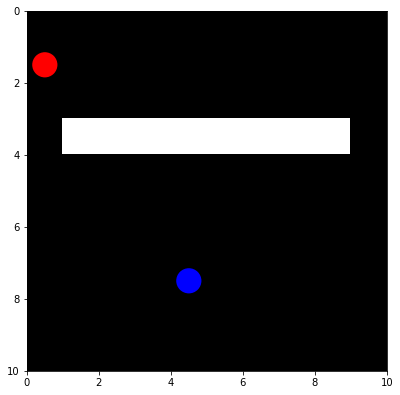

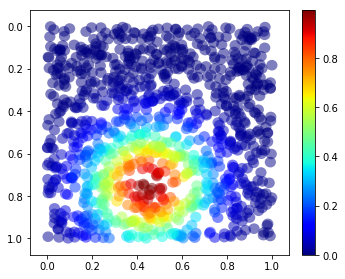

In [4]:
#========================
# Environment Parameters
#======================== 
height = 10
width = 10

mazetype = 'bar'
portshift = 'none'

obs_rho = 0.0 #obstacle density

# specify number of place cells and 
# full width half max of gaussian distribution of pc sensitivity
place_cells = 1000
fwhm = 0.25 # NB: place cell full width half max must be in (0,1)


#make environment
maze = eu.gridworld([height, width],rho=obs_rho,num_pc=place_cells, pc_fwhm=fwhm, maze_type=mazetype, port_shift = portshift)
#show environment
eu.make_env_plots(maze,1,1)

## test out gridworld wrapper. 
env = eu.gymworld(maze)

In [6]:
#=====================
# Training Parameters
#=====================
#trial parameters
NUM_TRIALS = 20000
NUM_EVENTS = 300

discount_factor = 0.98

#agent parameters
dims = [len(maze.net_state[0]),100,50,len(maze.actionlist)]
model = au.AC_Net(dims)

#learning parameters
eta = 5e-4 #gradient descent learning rate
opt = au.optim.Adam(model.parameters(), lr = eta)

In [9]:
reload(eu)
EC__ = eu.ep_mem(model,100)

In [10]:
#==================================
# Set up Data Recording Structures
#==================================
print_freq = 1./10
total_reward = [] #track total reward achieved in trial 
total_loss = [[],[]] #[actor loss, critic loss]

# data frames for value and policy maps
val_maps = []
pol_maps = []

# record current time before beginning of trial
print "Run started: ", strftime("%a, %d %b %Y %H:%M:%S +0000", time.localtime())
runtime= time.time()
blocktime = time.time()

#reset agent policy/value maps
value_map = maze.empty_map
policy_map  = np.zeros((height, width), dtype=[('action_taken', 'i4'),
                                            ('taken_prob', 'f4'), 
                                            ('likely_action', 'i4'),
                                            ('likely_prob', 'f4')])
t_check = time.time()
timestamp = 1
EC__.reset_cache()
#==================================
# Run Trial
#==================================
for trial in xrange(NUM_TRIALS):
    trial_start = time.time()
    
    env.reset()
    
    reward_sum = 0
     
    state = Variable(torch.FloatTensor(env.state))
    v_last = 0
    for event in xrange(NUM_EVENTS):
        choice, policy, value = au.select_action(model,state)
        #action = maze.actionlist[choice]
        choice_prob = policy[choice]
        
        if event < NUM_EVENTS: 
            next_state = maze.move(action)
            
        model.rewards.append(maze.rwd)
        # update state
        state = Variable(torch.FloatTensor(next_state))

        delta = maze.rwd - value - v_last
        #EC__.add_mem(tuple(maze.net_state[0]), choice, delta, timestamp)
        reward_sum += maze.rwd
        v_last = value
        timestamp += 1
        
    value_map = au.generate_values(maze, model)
    p_loss, v_loss = au.finish_trial(model, discount_factor,opt)
    total_loss[0].append(p_loss.data[0])
    total_loss[1].append(v_loss.data[0])
    total_reward.append(reward_sum)
    val_maps.append(value_map.copy())
    
    # print reward measure
    if trial%(print_freq*NUM_TRIALS)==0 or trial == NUM_TRIALS-1: 
        print "Trial {0} finished w total reward = {1} (Avg {2:.3f})".format(trial, reward_sum, float(reward_sum)/float(NUM_EVENTS)), "Block took {0:.3f}".format(time.time()-blocktime)
        blocktime = time.time() 
    
print "Run took {0:.3f}".format(time.time()-runtime)


Run started:  Wed, 28 Feb 2018 15:22:10 +0000
Trial 0 finished w total reward = 1 (Avg 0.003) Block took 0.174


KeyboardInterrupt: 

In [ ]:
plt.figure(0)
plt.plot(np.arange(len(total_loss[0])), total_loss[0], label='ploss')
plt.plot(total_loss[1], label='vloss')
plt.legend(loc=0)

plt.figure(1)
plt.plot(np.arange(len(total_loss[0])),total_reward, label='rwd')
plt.legend(loc=0)
plt.show()

In [ ]:
eu.print_value_maps(maze,val_maps)

In [ ]:
reload(eu)
eu.print_value_maps(maze,val_maps,maps=845)

In [ ]:
reload(eu)
eu.print_value_maps(maze,val_maps,maps=1045)

In [ ]:
# make fake memory dictionary for testing
num_inputs = 5 #706
num_actions = 6
cache_limit = 50

d = {}
for i in xrange(cache_limit):
    key = tuple(np.random.randn(num_inputs))
    action = np.zeros(num_actions)
    action[np.random.choice(np.arange(num_actions))] = 1
    delta = np.random.randn(1)*100
    timestamp = i
    d[key] = action*delta, i
    
# 
memory_envelope = 1 
def make_pval(cur_time, mem_times,deltas):
    if type(mem_times) == list:
        pvals = []
        for i in xrange(len(mem_times)):
            p = ((cur_time - mem_times[i])/cur_time)*deltas[i]
            pval = 1-1/np.cosh(p/memory_envelope)
            pvals.append(pval)
    else:
        print "Error in retrieving persistence values"
    return pvals

print(make_pval(100, [10,13,1,45], np.arange(4)))
test = [v[1] for k, v in d.items()]
print d[d.keys()[np.argmin(test)]][1]
print "## ", d.keys()[0]

In [ ]:
### 3 interactive value map plot
%matplotlib notebook

fig = plt.figure(3)
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(maze.x)
Y = np.arange(maze.y)
X, Y = np.meshgrid(X, Y)
print X,Y
Z = val_maps[-1]

# Plot the surface.
zlimz= [np.nanmin(val_maps), np.nanmax(val_maps)]
surf = ax.plot_surface(X, Y, Z, cmap=cm.Spectral_r, vmin=zlimz[0], vmax = zlimz[1])
#a = ax.plot_surface()

# Customize the z axis.
ax.set_zlim(zlimz[0], zlimz[1])
ax.invert_xaxis()
#ax.axis('equal')


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()